# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [87]:
%matplotlib inline

# Package to filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data Loading and other standard packages
import sqlite3
import nltk
import string
import re
import pickle
import os
import time
import string
import pickle
import pandas as pd
import numpy as np
from scipy import interp
from tqdm import tqdm
from scipy.sparse import find
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import coo_matrix, vstack


# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing packages
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

# Packages related to text processing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn import decomposition
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Packages for performance metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# Packages for crossvalidation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold

# Model packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC


In [88]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [89]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [90]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [91]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [92]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [93]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [94]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [95]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [96]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [97]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [98]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [99]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [100]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [101]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [102]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [103]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [104]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [105]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [106]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [107]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

## Time based splitting
* Sort the data based on `Time` column
* Get the 80% data for train and 20% data on test

In [108]:
# time based splitting for a dataframe
def split_time_based(df, time_col, train_perc):
    if type(df).__name__ != 'DataFrame':
        print("Please provide a dataframe!")
    if type(time_col).__name__ != 'list':
        print("Please porvide the time column as list")
    # Sort the dataframe based on time column
    df.sort_values(by=time_col, inplace=True)
    df_row, df_col = df.shape
    train_row = round(df_row * (train_perc/100))
    test_row = df_row - train_row
    return df.head(train_row), df.tail(test_row)

In [109]:
# Splitting the data based on Time column, where train=80% and test=20%
final_train, final_test = split_time_based(final, ['Time'], 80)
print(final_train.shape)
print(final_test.shape)

(70218, 10)
(17555, 10)


In [110]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_train = []
# tqdm is for printing the status bar
for sentance in tqdm(final_train['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_train.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 70218/70218 [00:19<00:00, 3563.26it/s]


In [111]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_test = []
# tqdm is for printing the status bar
for sentance in tqdm(final_test['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_test.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 17555/17555 [00:04<00:00, 3577.63it/s]


In [112]:
print("Train: ",len(preprocessed_reviews_train))
print("Test: ",len(preprocessed_reviews_test))

Train:  70218
Test:  17555


In [113]:
y_train = final_train['Score']
y_test = final_test['Score']

y_train = y_train.values
y_test = y_test.values

# [4] Featurization

## [4.1] BAG OF WORDS

In [114]:
#BoW for Train data
count_vect = CountVectorizer(min_df=10) #in scikit-learn
count_vect.fit(preprocessed_reviews_train)
bow_features = count_vect.get_feature_names()
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_train = count_vect.transform(preprocessed_reviews_train)
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70218, 49074)
the number of unique words  49074


In [115]:
#BoW for Test data
final_counts_test = count_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17555, 49074)
the number of unique words  49074


## [4.2] TF-IDF

In [141]:
#TFIDF on Train data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews_train)
tfidf_features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_train = tf_idf_vect.transform(preprocessed_reviews_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aa coffee', 'aa cups', 'aa dark', 'aa extra', 'aa favorite', 'aa kona', 'aa may', 'aa not', 'aa part']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70218, 1188957)
the number of unique words including both unigrams and bigrams  1188957


In [142]:
# TFIDF on Test data
final_tf_idf_test = tf_idf_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (17555, 1188957)
the number of unique words including both unigrams and bigrams  1188957


## [4.3] Word2Vec

In [75]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
list_of_sentance_test=[]
for sentance in preprocessed_reviews_train:
    list_of_sentance_train.append(sentance.split())
for sentance in preprocessed_reviews_test:
    list_of_sentance_test.append(sentance.split())

# Applying to W2V model on train data
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=500, workers=4) # min count --> ignore those words having count less than 5, size --> dimensions for each word

In [76]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15761
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [77]:
# average Word2Vec on Train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70218/70218 [01:30<00:00, 777.49it/s]


70218
500


In [78]:
# average Word2Vec on Test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:23<00:00, 753.99it/s]


17555
500


#### [4.3.1.2] TFIDF weighted W2v

In [79]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [80]:
# TF-IDF weighted Word2Vec for Train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(500) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 70218/70218 [23:17<00:00, 50.24it/s]


In [81]:
# TF-IDF weighted Word2Vec for Test data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(500) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [05:31<00:00, 52.92it/s]


### Pickling the data
* Pickling the train and test data for all the implementations
* BoW
* TFIDF
* Avg-W2Vec
* TFIDF W2Vec

In [82]:
import pickle

bow_train = 'bow_train.pkl'
bow_test = 'bow_test.pkl'
tfidf_train = 'tfidf_train.pkl'
tfidf_test = 'tfidf_test.pkl'
avgw2v_train = 'avgw2v_train.pkl'
avgw2v_test = 'avgw2v_test.pkl'
tfidfw2v_train = 'tfidfw2v_train.pkl'
tfidfw2v_test = 'tfidfw2v_test.pkl'
bow_features_f = 'bow_features.pkl'
tfidf_features_f = 'tfidf_features.pkl'
w2v_words_f = 'w2v_words.pkl'

obj1 = open(bow_features_f,'wb')
pickle.dump(bow_features, obj1)
obj1.close()
obj1 = open(tfidf_features_f,'wb')
pickle.dump(tfidf_features, obj1)
obj1.close()
obj1 = open(w2v_words_f,'wb')
pickle.dump(w2v_words, obj1)
obj1.close()

obj1 = open(bow_train,'wb')
pickle.dump(final_counts_train, obj1)
obj1.close()

obj2 = open(bow_test,'wb')
pickle.dump(final_counts_test, obj2)
obj2.close()

obj3 = open(tfidf_train,'wb')
pickle.dump(final_tf_idf_train, obj3)
obj3.close()

obj4 = open(tfidf_test,'wb')
pickle.dump(final_tf_idf_test, obj4)
obj4.close()

obj5 = open(avgw2v_train,'wb')
pickle.dump(sent_vectors_train, obj5)
obj5.close()

obj6 = open(avgw2v_test,'wb')
pickle.dump(sent_vectors_test, obj6)
obj6.close()

obj7 = open(tfidfw2v_train,'wb')
pickle.dump(tfidf_sent_vectors_train, obj7)
obj7.close()

obj8 = open(tfidfw2v_test,'wb')
pickle.dump(tfidf_sent_vectors_test, obj8)
obj8.close()

In [83]:
# Pickle class data
import pickle
y_train_file = 'y_train.pkl'
y_test_file = 'y_test.pkl'

obj9 = open(y_train_file,'wb')
pickle.dump(y_train, obj9)
obj9.close()

obj10 = open(y_test_file,'wb')
pickle.dump(y_test, obj10)
obj10.close()

### Unpickle the files before processing

In [155]:
import pickle

bow_train = 'bow_train.pkl'
bow_test = 'bow_test.pkl'
tfidf_train = 'tfidf_train.pkl'
tfidf_test = 'tfidf_test.pkl'
avgw2v_train = 'avgw2v_train.pkl'
avgw2v_test = 'avgw2v_test.pkl'
tfidfw2v_train = 'tfidfw2v_train.pkl'
tfidfw2v_test = 'tfidfw2v_test.pkl'
bow_features_f = 'bow_features.pkl'
tfidf_features_f = 'tfidf_features.pkl'
w2v_words_f = 'w2v_words.pkl'

obj1 = open(bow_features_f,'rb')
bow_features = pickle.load(obj1)
obj1.close()
obj1 = open(tfidf_features_f,'rb')
tfidf_features = pickle.load(obj1)
obj1.close()
obj1 = open(w2v_words_f,'rb')
w2v_words = pickle.load(obj1)
obj1.close()

obj1 = open(bow_train,'rb')
final_counts_train = pickle.load(obj1)
obj1.close()

obj2 = open(bow_test,'rb')
final_counts_test = pickle.load(obj2)
obj2.close()

obj3 = open(tfidf_train,'rb')
final_tf_idf_train = pickle.load(obj3)
obj3.close()

obj4 = open(tfidf_test,'rb')
final_tf_idf_test = pickle.load(obj4)
obj4.close()

obj5 = open(avgw2v_train,'rb')
sent_vectors_train = pickle.load(obj5)
obj5.close()

obj6 = open(avgw2v_test,'rb')
sent_vectors_test = pickle.load(obj6)
obj6.close()

obj7 = open(tfidfw2v_train,'rb')
tfidf_sent_vectors_train = pickle.load(obj7)
obj7.close()

obj8 = open(tfidfw2v_test,'rb')
tfidf_sent_vectors_test = pickle.load(obj8)
obj8.close()

In [156]:
# Unpickle class data
import pickle
y_train_file = 'y_train.pkl'
y_test_file = 'y_test.pkl'

obj9 = open(y_train_file,'rb')
y_train = pickle.load(obj9)
obj9.close()

obj10 = open(y_test_file,'rb')
y_test = pickle.load(obj10)
obj10.close()

In [157]:
hyper_param = [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4]
gamma = [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4]
regu_param = ['l1','l2']

# Applying SVM

In [158]:
#defining function to apply RBF SVM using SGDClassifier
def apply_rbf_svm(x_train, y_train, C_values, cross_val_number,gamma_vals):
    #tscv = TimeSeriesSplit(n_splits=cross_val_number)
    
    # define RBF SVM to use in crossvalidation
    parameter = {'C':C_values, 'gamma':gamma_vals}
    sv = SVC()
    clf = GridSearchCV(sv, parameter, cv=cross_val_number, scoring='roc_auc', n_jobs=1, verbose=1) #Use GridSearchCV for hyper parameter tuning
    clf.fit(x_train, y_train)
    return clf

In [42]:
#defining function to apply RBF SVM using SGDClassifier
def apply_linear_svm(x_train, y_train, alpha_values, cross_val_number, regularization_param):
    #tscv = TimeSeriesSplit(n_splits=cross_val_number)
    
    # define Linear SVM to use in crossvalidation
    parameter = {'alpha':alpha_values, 'penalty':regularization_param}
    sv = SGDClassifier()
    clf = GridSearchCV(sv, parameter, cv=cross_val_number, scoring='roc_auc', n_jobs=1, verbose=1) #Use GridSearchCV for hyper parameter tuning
    clf.fit(x_train, y_train)
    return clf

In [43]:
# Define Function to plot AUC vs alpha curve
def plot_auc_C_curve(xaxis1, yaxis1, xaxis2, yaxis2, title, xlab, ylab):
    plt.title(title)
    plt.plot(xaxis1, yaxis1)
    plt.plot(xaxis2, yaxis2)
    plt.legend(('Train', 'Test'))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [44]:
# Define function to Plot the ROC curve
def plot_roc_curve_for_test(fpr, tpr, title):
    plt.title(title)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
    plt.plot(fpr, tpr, color='b')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [45]:
# Define function to standardize data
def perform_standardization(x_train, x_test):
    if (type(x_train).__name__ == 'csr_matrix') and (type(x_test).__name__ == 'csr_matrix'):
        scaler = MaxAbsScaler().fit(x_train)
        x_train_std = scaler.transform(x_train)
        x_test_std = scaler.transform(x_test)
        return x_train_std, x_test_std
    elif (type(x_train).__name__ == 'coo_matrix') and (type(x_test).__name__ == 'coo_matrix'):
        scaler = MaxAbsScaler().fit(x_train)
        x_train_std = scaler.transform(x_train)
        x_test_std = scaler.transform(x_test)
        return x_train_std, x_test_std
    else:
        scaler = StandardScaler().fit(x_train)
        x_train_std = scaler.transform(x_train)
        x_test_std = scaler.transform(x_test)
        return x_train_std, x_test_std

In [46]:
# Define function for word cloud
def create_word_cloud(data,font_sz, fig_size):
    plt.figure(figsize=fig_size)

    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
            background_color='white',
            stopwords=stopwords,
            max_words=200,
            max_font_size=font_sz, 
            scale=3,
            random_state=1
        ).generate(str(data))
    plt.imshow(wordcloud)
    plt.show()

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [118]:
# Standardize the data
final_counts_train_std, final_counts_test_std = perform_standardization(final_counts_train, final_counts_test)


In [119]:
%time
bow_lin_clf = apply_linear_svm(final_counts_train_std, y_train, hyper_param, 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   27.6s finished


In [120]:
# Check the best estimator
bow_lin_clf.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

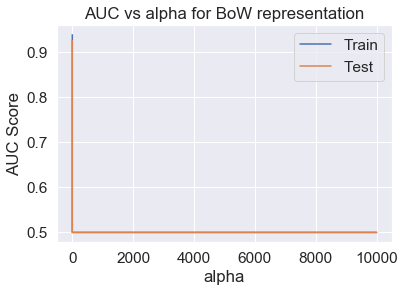

In [121]:
#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, bow_lin_clf.cv_results_['mean_train_score'][0::2], hyper_param, bow_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### So We can see that the above curve is falling very sharply fter 0.0001 so we will try to change the hyper parameter more

In [122]:
%time
bow_lin_clf = apply_linear_svm(final_counts_train_std, y_train, [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   30.8s finished


In [123]:
# Check the best estimator
bow_lin_clf.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

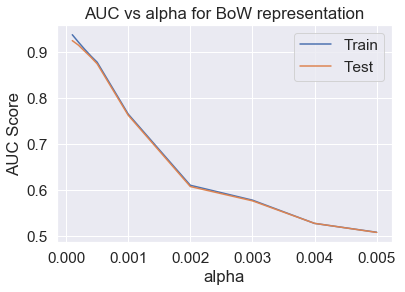

In [124]:
#plot AUC score vs C plot
plot_auc_C_curve([0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], bow_lin_clf.cv_results_['mean_train_score'][0::2], [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], bow_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### Here in this curve we can see the changes being happening slowly

In [125]:
print("Best HyperParameter: ",bow_lin_clf.best_params_)
print("Best Score: %.2f%%"%(bow_lin_clf.best_score_*100))

Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Score: 94.07%


Accuracy on test set: 90.817%
Precision on test set: 0.914
Recall on test set: 0.982
F1-Score on test set: 0.947



Confusion Matrix of test set


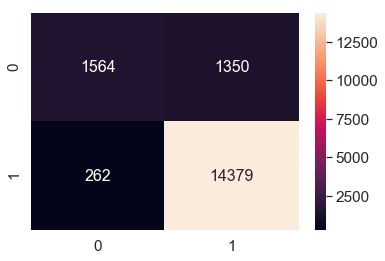

In [126]:
# Apply Linear SVM on Test data
lr_optimal = SGDClassifier(penalty=bow_lin_clf.best_params_['penalty'],alpha=bow_lin_clf.best_params_['alpha'])
lr_optimal.fit(final_counts_train_std, y_train)
pred = lr_optimal.predict(final_counts_test_std)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

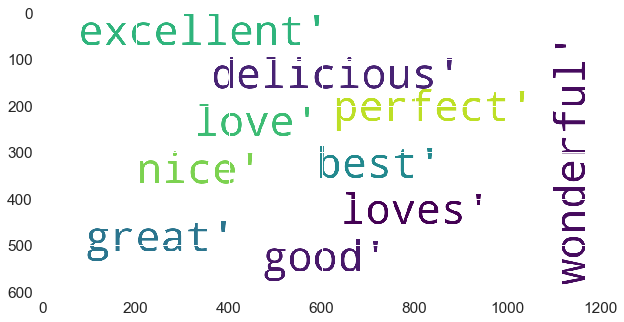

In [127]:
# For positive features
create_word_cloud(np.array(bow_features)[lr_optimal.coef_[0].argsort()[::-1][:10]],30,(10,6))

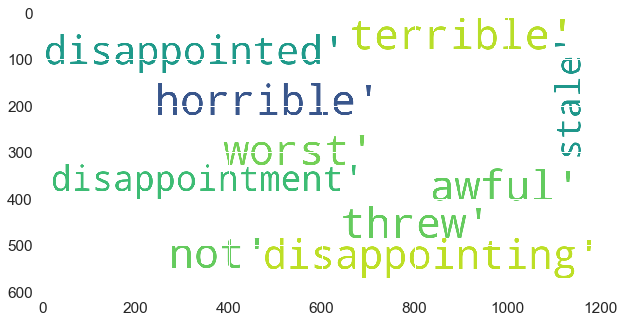

In [128]:
# For Negative features
create_word_cloud(np.array(bow_features)[lr_optimal.coef_[0].argsort()[:10]], 30, (10,6))

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [143]:
# Standardize the data
final_tf_idf_train_std, final_tf_idf_test_std = perform_standardization(final_tf_idf_train, final_tf_idf_test)



In [144]:
%time
tfidf_lin_clf = apply_linear_svm(final_tf_idf_train_std, y_train, hyper_param, 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.6min finished


In [145]:
# Check the best estimator
tfidf_lin_clf.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

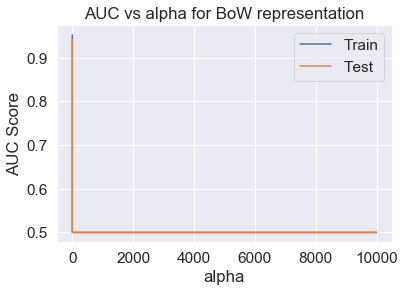

In [146]:
#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, tfidf_lin_clf.cv_results_['mean_train_score'][0::2], hyper_param, tfidf_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### So We can see that the above curve is falling very sharply fter 0.0001 so we will try to change the hyper parameter more

In [147]:
%time
tfidf_lin_clf = apply_linear_svm(final_tf_idf_train_std, y_train, [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.7min finished


In [148]:
# Check the best estimator
tfidf_lin_clf.best_estimator_

SGDClassifier(alpha=0.0002, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

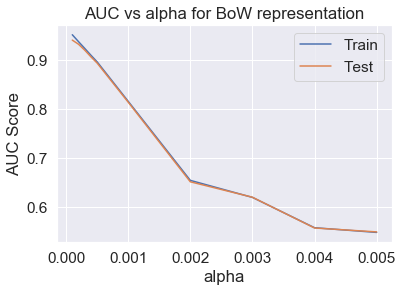

In [149]:
#plot AUC score vs C plot
plot_auc_C_curve([0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], tfidf_lin_clf.cv_results_['mean_train_score'][0::2], [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], tfidf_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### Here in this curve we can see the changes being happening slowly

In [150]:
print("Best HyperParameter: ",tfidf_lin_clf.best_params_)
print("Best Score: %.2f%%"%(tfidf_lin_clf.best_score_*100))

Best HyperParameter:  {'alpha': 0.0002, 'penalty': 'l2'}
Best Score: 96.19%


Accuracy on test set: 93.307%
Precision on test set: 0.945
Recall on test set: 0.977
F1-Score on test set: 0.961



Confusion Matrix of test set


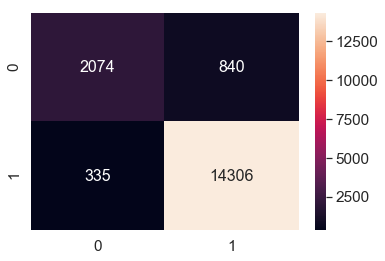

In [152]:
# Apply Linear SVM on Test data
lr_optimal = SGDClassifier(penalty=tfidf_lin_clf.best_params_['penalty'],alpha=tfidf_lin_clf.best_params_['alpha'])
lr_optimal.fit(final_tf_idf_train_std, y_train)
pred = lr_optimal.predict(final_tf_idf_test_std)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

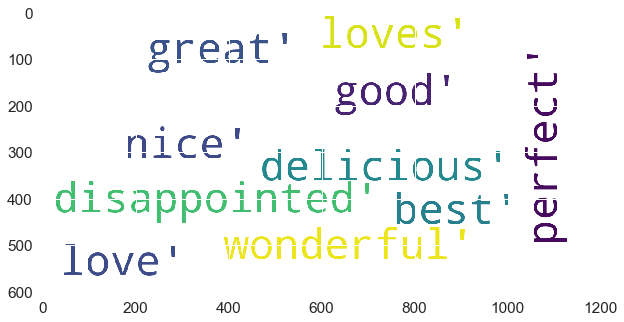

In [153]:
# For positive features
create_word_cloud(np.array(tfidf_features)[lr_optimal.coef_[0].argsort()[::-1][:10]], 30, (10,6))

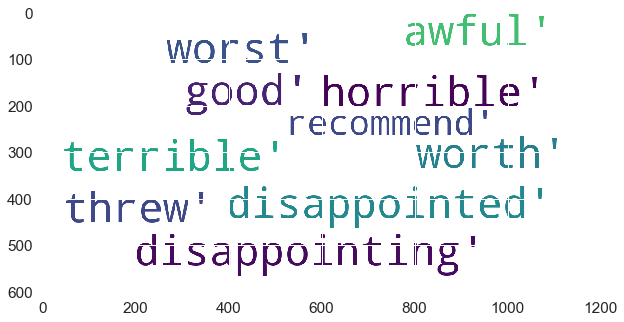

In [154]:
# For negative features
create_word_cloud(np.array(tfidf_features)[lr_optimal.coef_[0].argsort()[:10]], 30, (10,6))

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [30]:
# Standardize the data
sent_vectors_train_std, sent_vectors_test_std = perform_standardization(sent_vectors_train, sent_vectors_test)

In [31]:
%time
w2v_lin_clf = apply_linear_svm(sent_vectors_train_std, y_train, hyper_param, 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  2.8min finished


In [32]:
# Check the best estimator
w2v_lin_clf.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

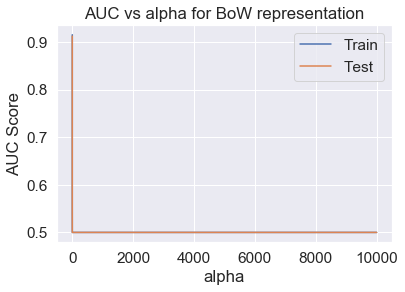

In [33]:
#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, w2v_lin_clf.cv_results_['mean_train_score'][0::2], hyper_param, w2v_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### So We can see that the above curve is falling very sharply fter 0.0001 so we will try to change the hyper parameter more

In [34]:
%time
w2v_lin_clf = apply_linear_svm(sent_vectors_train_std, y_train, [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


In [35]:
# Check the best estimator
w2v_lin_clf.best_estimator_

SGDClassifier(alpha=0.0003, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

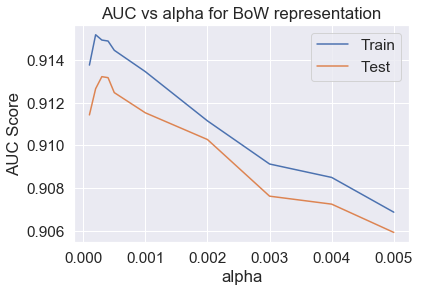

In [36]:
#plot AUC score vs C plot
plot_auc_C_curve([0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], w2v_lin_clf.cv_results_['mean_train_score'][0::2], [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], w2v_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### Here in this curve we can see the changes being happening slowly

In [37]:
print("Best HyperParameter: ",w2v_lin_clf.best_params_)
print("Best Score: %.2f%%"%(w2v_lin_clf.best_score_*100))

Best HyperParameter:  {'alpha': 0.0003, 'penalty': 'l1'}
Best Score: 91.32%


Accuracy on test set: 89.325%
Precision on test set: 0.920
Recall on test set: 0.955
F1-Score on test set: 0.937



Confusion Matrix of test set


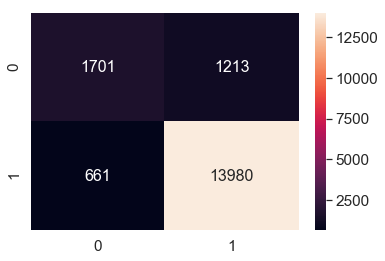

In [38]:
# Apply Linear SVM on Test data
lr_optimal = SGDClassifier(penalty=tfidf_lin_clf.best_params_['penalty'],alpha=tfidf_lin_clf.best_params_['alpha'])
lr_optimal.fit(sent_vectors_train_std, y_train)
pred = lr_optimal.predict(sent_vectors_test_std)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### *** W2Vec vectorizer gave high accuracy and the True-Negaive value is higher and as expected

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [39]:
# Standardize the data
tfidf_sent_vectors_train_std, tfidf_sent_vectors_test_std = perform_standardization(tfidf_sent_vectors_train, tfidf_sent_vectors_test)

In [40]:
%time
tfidf_w2v_lin_clf = apply_linear_svm(tfidf_sent_vectors_train_std, y_train, hyper_param, 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  2.8min finished


In [41]:
# Check the best estimator
tfidf_w2v_lin_clf.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

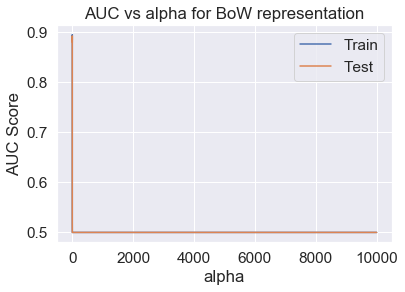

In [42]:
#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, tfidf_w2v_lin_clf.cv_results_['mean_train_score'][0::2], hyper_param, tfidf_w2v_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### So We can see that the above curve is falling very sharply fter 0.0001 so we will try to change the hyper parameter more

In [43]:
%time
tfidf_w2v_lin_clf = apply_linear_svm(tfidf_sent_vectors_train_std, y_train, [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.8min finished


In [44]:
# Check the best estimator
tfidf_w2v_lin_clf.best_estimator_

SGDClassifier(alpha=0.0005, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

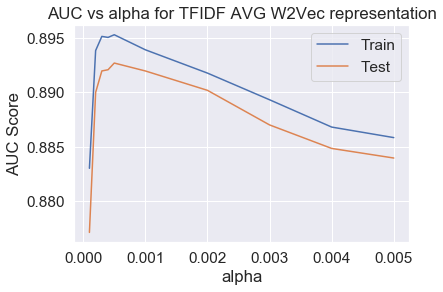

In [45]:
#plot AUC score vs C plot
plot_auc_C_curve([0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], tfidf_w2v_lin_clf.cv_results_['mean_train_score'][0::2], [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], tfidf_w2v_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for TFIDF AVG W2Vec representation', 'alpha', 'AUC Score')

### Here in this curve we can see the changes being happening slowly

In [46]:
print("Best HyperParameter: ",tfidf_w2v_lin_clf.best_params_)
print("Best Score: %.2f%%"%(tfidf_w2v_lin_clf.best_score_*100))

Best HyperParameter:  {'alpha': 0.0005, 'penalty': 'l1'}
Best Score: 89.27%


Accuracy on test set: 87.992%
Precision on test set: 0.909
Recall on test set: 0.951
F1-Score on test set: 0.930



Confusion Matrix of test set


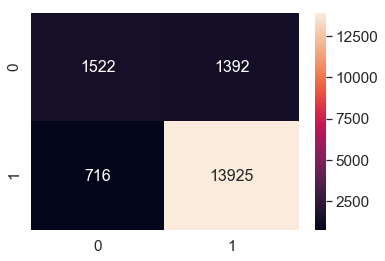

In [47]:
# Apply Linear SVM on Test data
lr_optimal = SGDClassifier(penalty=tfidf_w2v_lin_clf.best_params_['penalty'],alpha=tfidf_w2v_lin_clf.best_params_['alpha'])
lr_optimal.fit(tfidf_sent_vectors_train_std, y_train)
pred = lr_optimal.predict(tfidf_sent_vectors_test_std)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### *** TFIDF avg W2Vec vectorizer gave high accuracy and the True-Negaive value is lower than avg W2Vec

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [159]:
# Standardize the data
final_counts_train_std, final_counts_test_std = perform_standardization(final_counts_train, final_counts_test)


In [0]:
%time
bow_lin_clf = apply_rbf_svm(final_counts_train_std[:20000], y_train[:20000], hyper_param, 2,gamma)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 81.8min finished


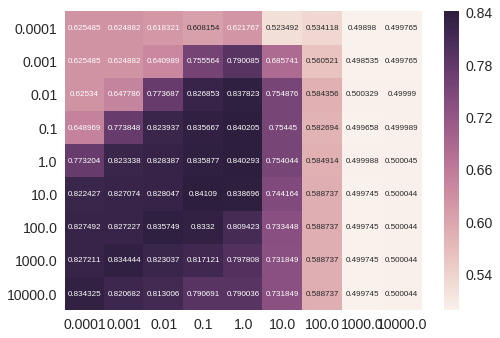

In [31]:
accuracy=bow_lin_clf.cv_results_['mean_test_score'].reshape(len(hyper_param),len(gamma))
df=pd.DataFrame(accuracy, index=hyper_param, columns=gamma)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

In [159]:
sns.heatmap(df, annot=True,annot_kws={"size": 8}, fmt='g')# Check the best estimator
bow_lin_clf.best_estimator_

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

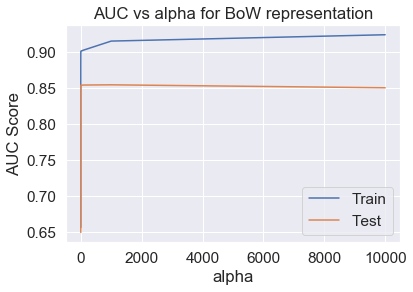

In [161]:
#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, bow_lin_clf.cv_results_['mean_train_score'], hyper_param, bow_lin_clf.cv_results_['mean_test_score'],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

In [162]:
print("Best HyperParameter: ",bow_lin_clf.best_params_)
print("Best Score: %.2f%%"%(bow_lin_clf.best_score_*100))

Best HyperParameter:  {'C': 1000}
Best Score: 85.48%


Accuracy on test set: 87.675%
Precision on test set: 0.886
Recall on test set: 0.978
F1-Score on test set: 0.930



Confusion Matrix of test set


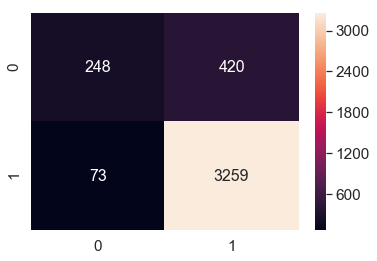

In [165]:
# Apply Linear SVM on Test data
lr_optimal = SVC(C=bow_lin_clf.best_params_['C'])
lr_optimal.fit(final_counts_train_std[:20000], y_train[:20000])
pred = lr_optimal.predict(final_counts_test_std[:4000])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test[:4000], pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test[:4000], pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test[:4000], pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test[:4000], pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test[:4000], pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [13]:
# Standardize the data
final_tf_idf_train_std, final_tf_idf_test_std = perform_standardization(final_tf_idf_train, final_tf_idf_test)


In [35]:
%time
tfidf_rbf_clf = apply_rbf_svm(final_tf_idf_train_std[:20000], y_train[:20000], hyper_param, 2, gamma)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 85.7min finished


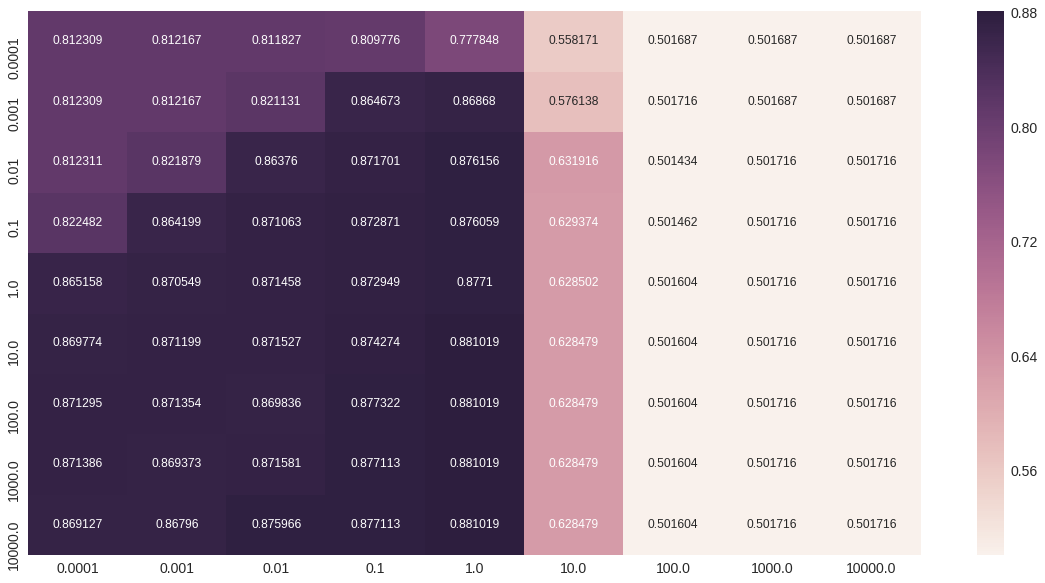

In [40]:
accuracy=tfidf_rbf_clf.cv_results_['mean_test_score'].reshape(len(hyper_param),len(gamma))
df=pd.DataFrame(accuracy, index=hyper_param, columns=gamma)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

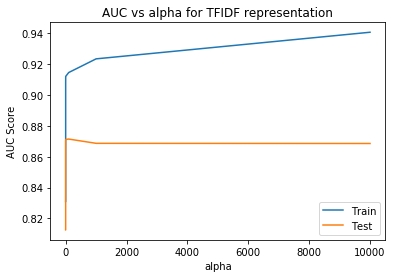

In [16]:
accuracy=tfidf_rbf_clf.cv_results_['mean_test_score'].reshape(len(hyper_param),len(gamma))
df=pd.DataFrame(accuracy, index=hyper_param, columns=gamma)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, tfidf_rbf_clf.cv_results_['mean_train_score'], hyper_param, tfidf_rbf_clf.cv_results_['mean_test_score'],
                    'AUC vs alpha for TFIDF representation', 'alpha', 'AUC Score')

In [17]:
print("Best HyperParameter: ",tfidf_rbf_clf.best_params_)
print("Best Score: %.2f%%"%(tfidf_rbf_clf.best_score_*100))

Best HyperParameter:  {'C': 100}
Best Score: 87.15%


Accuracy on test set: 87.600%
Precision on test set: 0.879
Recall on test set: 0.987
F1-Score on test set: 0.930



Confusion Matrix of test set


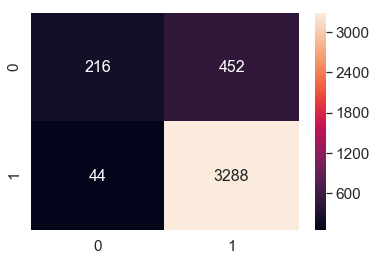

In [18]:
# Apply Linear SVM on Test data
lr_optimal = SVC(C=tfidf_rbf_clf.best_params_['C'])
lr_optimal.fit(final_tf_idf_train_std[:20000], y_train[:20000])
pred = lr_optimal.predict(final_tf_idf_test_std[:4000])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test[:4000], pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test[:4000], pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test[:4000], pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test[:4000], pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test[:4000], pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### ** The TFIDF and BoW representation both gives a small True Negative value

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [19]:
# Standardize the data
sent_vectors_train_std, sent_vectors_test_std = perform_standardization(sent_vectors_train, sent_vectors_test)


In [20]:
%time
w2v_rbf_clf = apply_rbf_svm(sent_vectors_train_std[:20000], y_train[:20000], hyper_param, 2)

Wall time: 0 ns
Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 25.9min finished


In [21]:
# Check the best estimator
w2v_rbf_clf.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

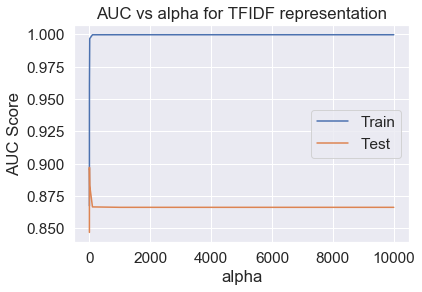

In [22]:
#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, w2v_rbf_clf.cv_results_['mean_train_score'], hyper_param, w2v_rbf_clf.cv_results_['mean_test_score'],
                    'AUC vs alpha for TFIDF representation', 'alpha', 'AUC Score')

In [23]:
print("Best HyperParameter: ",w2v_rbf_clf.best_params_)
print("Best Score: %.2f%%"%(w2v_rbf_clf.best_score_*100))

Best HyperParameter:  {'C': 1}
Best Score: 89.72%


Accuracy on test set: 89.200%
Precision on test set: 0.901
Recall on test set: 0.977
F1-Score on test set: 0.938



Confusion Matrix of test set


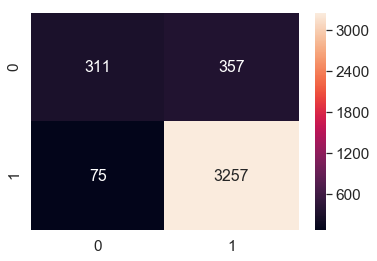

In [24]:
# Apply Linear SVM on Test data
lr_optimal = SVC(C=w2v_rbf_clf.best_params_['C'])
lr_optimal.fit(sent_vectors_train_std[:20000], y_train[:20000])
pred = lr_optimal.predict(sent_vectors_test_std[:4000])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test[:4000], pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test[:4000], pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test[:4000], pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test[:4000], pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test[:4000], pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### ** The Avg W2Vec gives a better True Negative value than TFIDF and BoW representation

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [26]:
# Standardize the data
tfidf_sent_vectors_train_std, tfidf_sent_vectors_test_std = perform_standardization(tfidf_sent_vectors_train, tfidf_sent_vectors_test)


In [27]:
%time
tfidf_w2v_rbf_clf = apply_rbf_svm(tfidf_sent_vectors_train_std[:20000], y_train[:20000], hyper_param, 2)

Wall time: 0 ns
Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 25.8min finished


In [28]:
# Check the best estimator
tfidf_w2v_rbf_clf.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

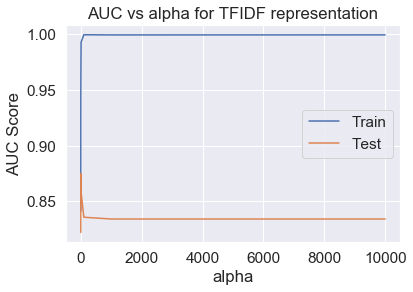

In [29]:
#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, tfidf_w2v_rbf_clf.cv_results_['mean_train_score'], hyper_param, tfidf_w2v_rbf_clf.cv_results_['mean_test_score'],
                    'AUC vs alpha for TFIDF representation', 'alpha', 'AUC Score')

In [30]:
print("Best HyperParameter: ",tfidf_w2v_rbf_clf.best_params_)
print("Best Score: %.2f%%"%(tfidf_w2v_rbf_clf.best_score_*100))

Best HyperParameter:  {'C': 0.1}
Best Score: 87.51%


Accuracy on test set: 88.050%
Precision on test set: 0.885
Recall on test set: 0.985
F1-Score on test set: 0.932



Confusion Matrix of test set


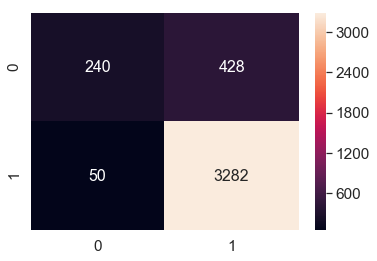

In [31]:
# Apply Linear SVM on Test data
lr_optimal = SVC(C=w2v_rbf_clf.best_params_['C'])
lr_optimal.fit(tfidf_sent_vectors_train_std[:20000], y_train[:20000])
pred = lr_optimal.predict(tfidf_sent_vectors_test_std[:4000])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test[:4000], pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test[:4000], pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test[:4000], pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test[:4000], pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test[:4000], pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### ** The Avg W2Vec gives a better True Negative value than TFIDF Avg W2vec

# [6] Apply Linear SVM - With feature Engineering 

## Feature Engineering
* Other than using the `review text` we will extract two more features for our model to train and test
* Feature1 : `Character length` of each review text
* Feature2 : `Character density` for each review - (total characters in the i'th review / Total characters in the corpus)

In [48]:
# For Train Data
feature_columns = ['RefinedText', 'CharLength', 'CharDensity']
reviews_train = pd.DataFrame({feature_columns[0]:preprocessed_reviews_train})
del preprocessed_reviews_train
reviews_train.head()

,RefinedText
0,bought apartment infested fruit flies hours tr...
1,really good idea final product outstanding use...
2,received shipment could hardly wait try produc...
3,nothing product bother link top page buy used ...
4,love stuff sugar free not rot gums tastes good...


In [49]:
total_chars = 0
for txt in reviews_train['RefinedText']:
    total_chars += len(txt)
print("Total characters in the corpus: {}".format(total_chars))

Total characters in the corpus: 18026634


In [50]:
reviews_train[feature_columns[1]] = reviews_train['RefinedText'].apply(len)
reviews_train[feature_columns[2]] = reviews_train[feature_columns[1]].apply(lambda x:x/total_chars)
reviews_train.head()

,RefinedText,CharLength,CharDensity
0,bought apartment infested fruit flies hours tr...,207,0.000011
1,really good idea final product outstanding use...,109,0.000006
2,received shipment could hardly wait try produc...,277,0.000015
3,nothing product bother link top page buy used ...,99,0.000005
4,love stuff sugar free not rot gums tastes good...,64,0.000004


In [51]:
# For Test Data
feature_columns = ['RefinedText', 'CharLength', 'CharDensity']
reviews_test = pd.DataFrame({feature_columns[0]:preprocessed_reviews_test})
del preprocessed_reviews_test
reviews_test.head()

,RefinedText
0,great product delivery quick buying favorite s...
1,bad product gave labs beagle times days dogs t...
2,really freshen mouth student nurse use help ri...
3,favorite bloody mary mix best one far readymad...
4,taste like fruit roll bits crunchy seeds overa...


In [52]:
total_chars = 0
for txt in reviews_test['RefinedText']:
    total_chars += len(txt)
print("Total characters in the corpus: {}".format(total_chars))

Total characters in the corpus: 4464612


In [53]:
reviews_test[feature_columns[1]] = reviews_test['RefinedText'].apply(len)
reviews_test[feature_columns[2]] = reviews_test[feature_columns[1]].apply(lambda x:x/total_chars)
reviews_test.head()

,RefinedText,CharLength,CharDensity
0,great product delivery quick buying favorite s...,120,0.000027
1,bad product gave labs beagle times days dogs t...,72,0.000016
2,really freshen mouth student nurse use help ri...,111,0.000025
3,favorite bloody mary mix best one far readymad...,69,0.000015
4,taste like fruit roll bits crunchy seeds overa...,230,0.000052


## [6.1] Featurization - For Feature Engineering

### [6.1.1] BAG OF WORDS

In [54]:
#BoW for Train data
count_vect = CountVectorizer(min_df=10)#, max_features=500) #in scikit-learn
count_vect.fit(reviews_train['RefinedText'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_train = count_vect.transform(reviews_train['RefinedText'])
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

some feature names  ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'abroad', 'absence', 'absent']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70218, 10349)
the number of unique words  10349


In [55]:
#BoW for Test data
final_counts_test = count_vect.transform(reviews_test['RefinedText'])
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17555, 10349)
the number of unique words  10349


### [6.1.2] TF-IDF

In [56]:
#TFIDF on Train data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))#, min_df=10, max_features=500)
tf_idf_vect.fit(reviews_train['RefinedText'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_train = tf_idf_vect.transform(reviews_train['RefinedText'])
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aa coffee', 'aa cups', 'aa dark', 'aa extra', 'aa favorite', 'aa kona', 'aa may', 'aa not', 'aa part']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70218, 1188957)
the number of unique words including both unigrams and bigrams  1188957


In [57]:
# TFIDF on Test data
final_tf_idf_test = tf_idf_vect.transform(reviews_test['RefinedText'])
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (17555, 1188957)
the number of unique words including both unigrams and bigrams  1188957


## [6.2] Linear SVM using BoW with feature Engineering

In [58]:
# Adding two more features to train data
final_counts_train = vstack([final_counts_train.T, reviews_train['CharLength'].values]).T
final_counts_train = vstack([final_counts_train.T, reviews_train['CharDensity'].values]).T
final_counts_train.get_shape()

(70218, 10351)

In [59]:
# Adding two more features to test data
final_counts_test = vstack([final_counts_test.T, reviews_test['CharLength'].values]).T
final_counts_test = vstack([final_counts_test.T, reviews_test['CharDensity'].values]).T
final_counts_test.get_shape()

(17555, 10351)

In [60]:
# Standardize the data
final_counts_train_std, final_counts_test_std = perform_standardization(final_counts_train, final_counts_test)


In [63]:
%time
bow_lin_clf = apply_linear_svm(final_counts_train_std, y_train, hyper_param, 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   24.0s finished


In [64]:
# Check the best estimator
bow_lin_clf.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

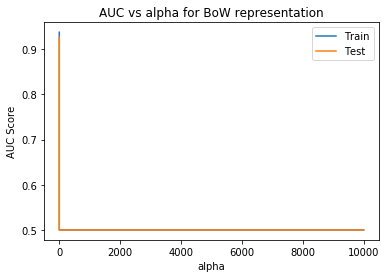

In [65]:
#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, bow_lin_clf.cv_results_['mean_train_score'][0::2], hyper_param, bow_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### So We can see that the above curve is falling very sharply fter 0.0001 so we will try to change the hyper parameter more

In [66]:
%time
bow_lin_clf = apply_linear_svm(final_counts_train_std, y_train, [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   27.5s finished


In [67]:
# Check the best estimator
bow_lin_clf.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

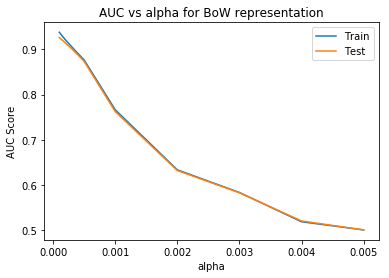

In [68]:
#plot AUC score vs C plot
plot_auc_C_curve([0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], bow_lin_clf.cv_results_['mean_train_score'][0::2], [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], bow_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### Here in this curve we can see the changes being happening slowly

In [69]:
print("Best HyperParameter: ",bow_lin_clf.best_params_)
print("Best Score: %.2f%%"%(bow_lin_clf.best_score_*100))

Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Score: 93.97%


Accuracy on test set: 90.789%
Precision on test set: 0.914
Recall on test set: 0.983
F1-Score on test set: 0.947



Confusion Matrix of test set


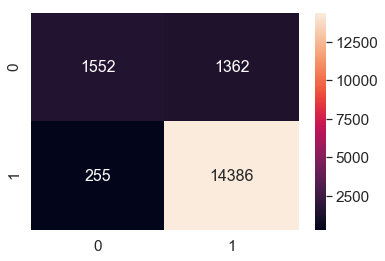

In [72]:
# Apply Linear SVM on Test data
lr_optimal = SGDClassifier(penalty=bow_lin_clf.best_params_['penalty'],alpha=bow_lin_clf.best_params_['alpha'])
lr_optimal.fit(final_counts_train_std, y_train)
pred = lr_optimal.predict(final_counts_test_std)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## [6.3] Linear SVM using TFIDF with feature Engineering

In [73]:
# Adding two more features to train data
final_tf_idf_train = vstack([final_tf_idf_train.T, reviews_train['CharLength'].values]).T
final_tf_idf_train = vstack([final_tf_idf_train.T, reviews_train['CharDensity'].values]).T
final_tf_idf_train.get_shape()

(70218, 1188959)

In [74]:
# Adding two more features to test data
final_tf_idf_test = vstack([final_tf_idf_test.T, reviews_test['CharLength'].values]).T
final_tf_idf_test = vstack([final_tf_idf_test.T, reviews_test['CharDensity'].values]).T
final_tf_idf_test.get_shape()

(17555, 1188959)

In [75]:
# Standardize the data
final_tf_idf_train_std, final_tf_idf_test = perform_standardization(final_tf_idf_train, final_tf_idf_test)


In [76]:
%time
tfidf_lin_clf = apply_linear_svm(final_tf_idf_train_std, y_train, hyper_param, 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.7min finished


In [77]:
# Check the best estimator
tfidf_lin_clf.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

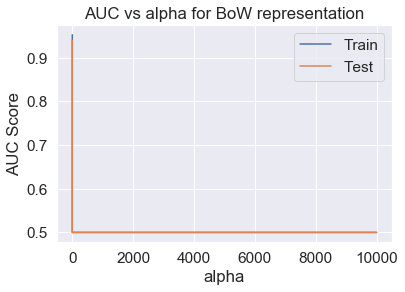

In [78]:
#plot AUC score vs C plot
plot_auc_C_curve(hyper_param, tfidf_lin_clf.cv_results_['mean_train_score'][0::2], hyper_param, tfidf_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### So We can see that the above curve is falling very sharply fter 0.0001 so we will try to change the hyper parameter more

In [79]:
%time
tfidf_lin_clf = apply_linear_svm(final_tf_idf_train_std, y_train, [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], 10, regu_param)

Wall time: 0 ns
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.7min finished


In [80]:
# Check the best estimator
tfidf_lin_clf.best_estimator_

SGDClassifier(alpha=0.0002, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

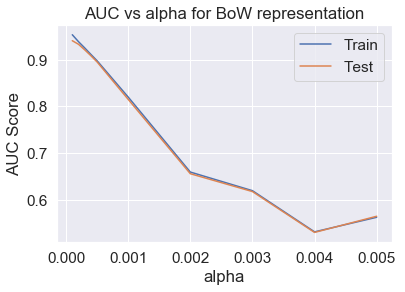

In [81]:
#plot AUC score vs C plot
plot_auc_C_curve([0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], tfidf_lin_clf.cv_results_['mean_train_score'][0::2], [0.0001,0.0002,0.0003,0.0004,0.0005,0.001,0.002,0.003,0.004,0.005], tfidf_lin_clf.cv_results_['mean_test_score'][0::2],
                    'AUC vs alpha for BoW representation', 'alpha', 'AUC Score')

### Here in this curve we can see the changes being happening slowly

In [82]:
print("Best HyperParameter: ",tfidf_lin_clf.best_params_)
print("Best Score: %.2f%%"%(tfidf_lin_clf.best_score_*100))

Best HyperParameter:  {'alpha': 0.0002, 'penalty': 'l2'}
Best Score: 96.21%


In [83]:
final_tf_idf_train_std.shape

(70218, 1188959)

Accuracy on test set: 93.210%
Precision on test set: 0.941
Recall on test set: 0.980
F1-Score on test set: 0.960



Confusion Matrix of test set


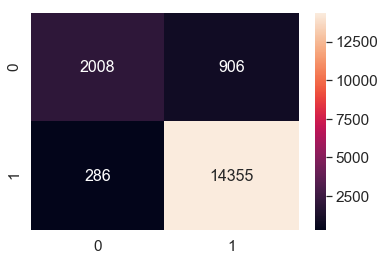

In [85]:
# Apply Linear SVM on Test data
lr_optimal = SGDClassifier(penalty=tfidf_lin_clf.best_params_['penalty'],alpha=tfidf_lin_clf.best_params_['alpha'])
lr_optimal.fit(final_tf_idf_train_std, y_train)
pred = lr_optimal.predict(final_tf_idf_test)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# [7] Conclusions

In [70]:
from prettytable import PrettyTable

In [71]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Kernel", "Hyper Parameter", "AUC","Accuracy", "Precision", "Recall", "F1 Score", "Feature Engineering"]

x.add_row(["Bow", "Linear", 0.0001, 89.10,87.67, 0.883, 0.982, 0.930, "No"])
x.add_row(["TFIDF", "Linear", 0.0001, 90.58,82.427, 0.835, 0.984, 0.903, "No"])
x.add_row(["W2Vec", "Linear", 0.0003, 91.32,89.325, 0.920, 0.955, 0.937, "No"])
x.add_row(["TFIDF W2Vec", "Linear", 0.0005, 89.27,87.992, 0.909, 0.951, 0.930, "No"])
x.add_row(["BoW", "RBF", 1000, 85.48,87.675, 0.886, 0.978, 0.930, "No"])
x.add_row(["TFIDF", "RBF", 100, 87.15,87.600, 0.879, 0.987, 0.930, "No"])
x.add_row(["W2Vec", "RBF", 1, 89.72,89.200, 0.901, 0.977, 0.938, "No"])
x.add_row(["TFIDF W2Vec", "RBF", 0.1, 87.51,88.050, 0.885, 0.985, 0.932, "No"])
x.add_row(["BoW", "RBF", 0.0001, 89.12,87.405, 0.880, 0.984, 0.929, "Yes"])
x.add_row(["TFIDF", "RBF", 0.0001, 90.59,82.119, 0.834, 0.980, 0.901, "Yes"])

print(x)

+-------------+--------+-----------------+-------+----------+-----------+--------+----------+---------------------+
|  Vectorizer | Kernel | Hyper Parameter |  AUC  | Accuracy | Precision | Recall | F1 Score | Feature Engineering |
+-------------+--------+-----------------+-------+----------+-----------+--------+----------+---------------------+
|     Bow     | Linear |      0.0001     |  89.1 |  87.67   |   0.883   | 0.982  |   0.93   |          No         |
|    TFIDF    | Linear |      0.0001     | 90.58 |  82.427  |   0.835   | 0.984  |  0.903   |          No         |
|    W2Vec    | Linear |      0.0003     | 91.32 |  89.325  |    0.92   | 0.955  |  0.937   |          No         |
| TFIDF W2Vec | Linear |      0.0005     | 89.27 |  87.992  |   0.909   | 0.951  |   0.93   |          No         |
|     BoW     |  RBF   |       1000      | 85.48 |  87.675  |   0.886   | 0.978  |   0.93   |          No         |
|    TFIDF    |  RBF   |       100       | 87.15 |   87.6   |   0.879   

### 1. From the above comparison we can say that the Linear karnel of SVM with Avg W2Vec representation has the best performance metric in this case
### 2. The feature Engineering doesn't change the performace heavily.
### 3. The TFIDF vectorizer has the worst performance with respect to its accuracy and the lowest True-Negative value amongst all